In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

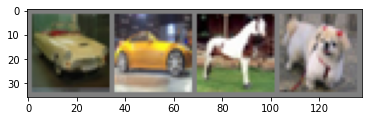

  car   car horse   dog


In [4]:
def imshow(img):
    img = img / 2 + 0.5 # unnnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# getting random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# showing images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[ii]] for ii in range(4)))


In [7]:
# Defining a CNN

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
        

In [8]:
# defining loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):
    running_loss = 0
    for ii, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.item()
        if ii % 2000 == 1999:  # print every 2000 minibatches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, ii + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.247
[1,  4000] loss: 1.917
[1,  6000] loss: 1.685
[1,  8000] loss: 1.576
[1, 10000] loss: 1.524
[1, 12000] loss: 1.451
[2,  2000] loss: 1.368
[2,  4000] loss: 1.362
[2,  6000] loss: 1.357
[2,  8000] loss: 1.294
[2, 10000] loss: 1.304
[2, 12000] loss: 1.244
Finished Training


In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

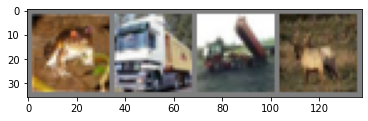

GroundTruth:   frog truck truck  deer


In [12]:
# Testing network data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[jj]] for jj in range(4)))

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[jj]] for jj in range(4)))

Predicted:   frog truck truck  deer


In [18]:
# checking against whole set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy on 10000 test images: %d %%' %( 100 * correct / total))

Accuracy on 10000 test images: 56 %


In [21]:
# seeing which classes performed well
class_correct = list(0. for ii in range(10))
class_total = list(0. for ii in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for ii in range(4):
            label = labels[ii]
            class_correct[label] += c[ii].item()
            class_total[label] += 1
            
for ii in range(10):
    print('Accuracy of %5s : %2d %%' %(
        classes[ii], 100 * class_correct[ii] / class_total[ii]))

Accuracy of plane : 71 %
Accuracy of   car : 57 %
Accuracy of  bird : 47 %
Accuracy of   cat : 60 %
Accuracy of  deer : 26 %
Accuracy of   dog : 31 %
Accuracy of  frog : 73 %
Accuracy of horse : 54 %
Accuracy of  ship : 71 %
Accuracy of truck : 63 %


In [22]:
# Training on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [23]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)